## Import Libraries

In [1]:
# for first LLM
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers.modeling_outputs import BaseModelOutput

# for second
from transformers import pipeline, T5ForConditionalGeneration, T5Tokenizer

from IPython.display import display, HTML
import torch
from tqdm.notebook import tqdm

## Choose Device (GPU / CPU)

In [2]:
# Automatically choose (prefer NVIDIA GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # OR choose device manually, be sure to comment other codes relevant to `device`
# device = torch.device("cuda")
# device = torch.device("cpu")

## Load BART model and tokenizer, Load summarizer and tokenizer

In [3]:
# Specify model name
model_name = "facebook/bart-base"
# model_name = "facebook/bart-large" # Recommend this one if your computer is okay with larger models

tokenizer_bart = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Specify model name
summarizer_name = "Falconsai/text_summarization"

tokenizer_sum = T5Tokenizer.from_pretrained(summarizer_name)
summarizer = T5ForConditionalGeneration.from_pretrained(summarizer_name).to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## A function adding AWGN noise to latent representation

In [4]:
def add_noise_with_snr(encoder_output, target_snr_db):
    """
    Add noise to the encoder output based on a target SNR in dB.
    
    Parameters:
    - encoder_output: torch.Tensor, the encoder's output (last_hidden_state).
    - target_snr_db: float, the desired signal-to-noise ratio in dB.
    
    Returns:
    - noisy_encoder_output: torch.Tensor, encoder output with added noise.
    """
    # Convert SNR from dB to linear scale
    target_snr_linear = 10 ** (target_snr_db / 10)
    
    # Calculate power of the signal
    signal_power = torch.mean(encoder_output ** 2)
    
    # Calculate required noise power for the target SNR
    noise_power = signal_power / target_snr_linear
    noise = torch.randn_like(encoder_output) * torch.sqrt(noise_power)
    
    # Add noise to the encoder output
    noisy_encoder_output = encoder_output + noise
    return noisy_encoder_output

## A function randomly masking words

In [5]:
import random
import numpy as np

def masking(input_text, prob):
    '''
    Substitutes word with <mask> according to Bernoull-distribution.
    
    Parameters:
    - input_text: text to be masked partly
    - prob: probability that each word is replaced by a mask
    
    Returns:
    - masked_text: masked version of input_text
    '''
    
    words = input_text.split()  # Split text into words
    masked_words = ["<mask>" if random.random() < prob else word for word in words]
    
    masked_text = " ".join(masked_words)
    return masked_text

### A function to extract hidden states

In [6]:
def extract_hidden_states(decoder_hidden_states: tuple):
    """
    Extract the hidden states of last layer in decoder block
    """
    last_column = [row[-1] for row in decoder_hidden_states]
    last_layer_hs = torch.stack(last_column).squeeze()  

    return last_layer_hs

## A function to align two tensors

In [7]:
def align_tensors(tensor_a, tensor_b):
    """
    Aligns two tensors along the first dimension by padding.

    Args:
        tensor_a (torch.Tensor): The first tensor.
        tensor_b (torch.Tensor): The second tensor.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The two tensors aligned along the first dimension.
    """
    # Get the first dimension sizes
    m, n = tensor_a.size(0), tensor_b.size(0)
    # Pad to the maximum length along the first dimension
    max_rows = max(m, n)
    if m < max_rows:
        padding = torch.zeros((max_rows - m, *tensor_a.shape[1:]), device=tensor_a.device)
        tensor_a = torch.cat([tensor_a, padding], dim=0)
    if n < max_rows:
        padding = torch.zeros((max_rows - n, *tensor_b.shape[1:]), device=tensor_b.device)
        tensor_b = torch.cat([tensor_b, padding], dim=0)

    return tensor_a, tensor_b

## Introduction of metrics

### Cosine similarity

In [8]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Mutual information

In [9]:
# using NPEET (referenced in MI paper) to calculate MI
import entropy_estimators as ee
import numpy as np

In [10]:
#This function is taken from the github of mutual information paper

def ksg(x, y, k=3):
    """
    Kraskov–Stogbauer–Grassberger (KSG) estimator of mutual information between two sentences represented as word embedding matrices x and y
    :param x: list of word embeddings for the first sentence
    :param y: list of word embeddings for the second sentence
    :return: KSG similarity measure between the two sentences
    """

    return ee.mi(x.T, y.T,k=3, base=np.e)

## `Fill in the blank` task

`original_text` contains the complete text <br>
`input_text_ls` contains the masked texts

In [11]:
original_text = """
Beginners BBQ Class Taking Place in Missoula! 
Do you want to get better at making delicious BBQ?
You will have the opportunity, put this on your calendar now. 
Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. 
He will be teaching a beginner level class for everyone who wants to get better with their culinary skills. 
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information. 
The cost to be in the class is $35 per person, and for spectators it is free. 
Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.
""".replace("\n", "")

input_text_ls = []
nr_rounds = 10

for _ in tqdm(range(nr_rounds)):
    input_text_ls.append(masking(original_text, 4/130))


  0%|          | 0/10 [00:00<?, ?it/s]

## Original

In [12]:
original_ids = tokenizer_sum(original_text, return_tensors="pt").input_ids.to(device)

with torch.no_grad():
    original_encoder_outputs = summarizer.encoder(input_ids=original_ids)
    
original_sum_output = summarizer.generate(input_ids=None, 
                                          encoder_outputs=original_encoder_outputs, 
                                          max_length=70, 
                                          output_hidden_states=True,
                                          return_dict_in_generate=True, 
                                          do_sample=True, 
                                          temperature=0.1)
original_summary = tokenizer_sum.decode(original_sum_output.sequences[0], skip_special_tokens=True)

em_original_summary = extract_hidden_states(original_sum_output.decoder_hidden_states)

## Baseline

In [14]:
em_baseline_summary = []

for i in tqdm(range(nr_rounds)):
    input_ids = tokenizer_bart(input_text_ls[i], return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        encoder_outputs = model.model.encoder(input_ids=input_ids)
        
    # first LLM
    baseline_outputs = model.generate(input_ids=None, 
                                      encoder_outputs=encoder_outputs,
                                      max_length=300,                   # Set maximum length for the generated text sequence
                                        min_length=100,                    # Set minimum length for the generated text sequence
                                        do_sample=True,                   # Enables sampling for diverse outputs, rather than greedy decoding
                                        num_beams=15,
                                        temperature = 0.15,
                                        early_stopping=True )
    baseline_text = tokenizer_bart.decode(baseline_outputs[0], skip_special_tokens=True)
   
    
    baseline_ids = tokenizer_sum(baseline_text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        baseline_encoder_outputs = summarizer.encoder(input_ids=baseline_ids)
        
    baseline_sum_output = summarizer.generate(input_ids=None, encoder_outputs=baseline_encoder_outputs, max_length=70, output_hidden_states=True,
                                            return_dict_in_generate=True, do_sample=True, temperature=0.1)
    baseline_summary = tokenizer_sum.decode(baseline_sum_output.sequences[0], skip_special_tokens=True)
    em_baseline_summary.append(extract_hidden_states(baseline_sum_output.decoder_hidden_states))
    

    

  0%|          | 0/10 [00:00<?, ?it/s]

## Noisy

In [30]:
# Define SNR range
# snr_range = list(range(-20, 21, 6)) + list(range(22, 55, 5)) + list(range(64, 101, 6)) 
snr_range = range(0, 21, 20)
cs_list = []
mi_list = []


for target_snr in tqdm(snr_range):
    for i in tqdm(range(nr_rounds)):
        cs_list_texts = []
        mi_list_texts = []
        
        input_ids = tokenizer_bart(input_text_ls[i], return_tensors="pt").input_ids.to(device)
        with torch.no_grad():
            encoder_outputs = model.model.encoder(input_ids=input_ids)
        
        # add noise
        noisy_encoder_output = add_noise_with_snr(encoder_outputs.last_hidden_state, target_snr)
        modified_encoder_outputs = BaseModelOutput(last_hidden_state=noisy_encoder_output)
        
        # first LLM
        noisy_outputs = model.generate(input_ids=None, encoder_outputs=modified_encoder_outputs, max_length=300,                   # Set maximum length for the generated text sequence
                                        min_length=100,                    # Set minimum length for the generated text sequence
                                        do_sample=True,                   # Enables sampling for diverse outputs, rather than greedy decoding
                                        num_beams=15,
                                        temperature = 0.15,
                                        early_stopping=True)
        noisy_text = tokenizer_bart.decode(noisy_outputs[0], skip_special_tokens=True)
        # print(noisy_text)
    
        # second LLM
        noisy_ids = tokenizer_sum(noisy_text, return_tensors="pt").input_ids.to(device)
        with torch.no_grad():
            noisy_encoder_outputs = summarizer.encoder(input_ids=noisy_ids)
        noisy_sum_output = summarizer.generate(input_ids=None, encoder_outputs=noisy_encoder_outputs, max_length=70, output_hidden_states=True,
                                            return_dict_in_generate=True, do_sample=True, temperature=0.1)
        noisy_summary = tokenizer_sum.decode(noisy_sum_output.sequences[0], skip_special_tokens=True)
        
        
        # get embeddings
        em_noisy_summary = extract_hidden_states(noisy_sum_output.decoder_hidden_states)
        
        # pad each embedding with embedding of baseline
        pad_em_baseline_summary, pad_em_noisy_summary = align_tensors(em_baseline_summary[i], em_noisy_summary)
        
        # calculate cs
        cs_list_texts.append(F.cosine_similarity(pad_em_baseline_summary, pad_em_noisy_summary, dim=-1).mean().item())
        # print(F.cosine_similarity(pad_em_baseline_summary, pad_em_noisy_summary, dim=0).mean().item())
    
        # calculate mi
        em_noisy_summary_np = em_noisy_summary.cpu().numpy()
        em_baseline_summary_np = em_baseline_summary[i].cpu().numpy()
        mi_list_texts.append(ksg(em_baseline_summary_np, em_noisy_summary_np))
    
    # for each snr calculate mean cs and mi
    cs_list.append(np.mean(cs_list_texts))
    mi_list.append(np.mean(mi_list_texts))
        
        

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
snr_range = list(map(float, np.concatenate((np.arange(-20, 20.5, 0.5), np.arange(20, 101, 1)))))
snr_range

## Comparison of baseline and original

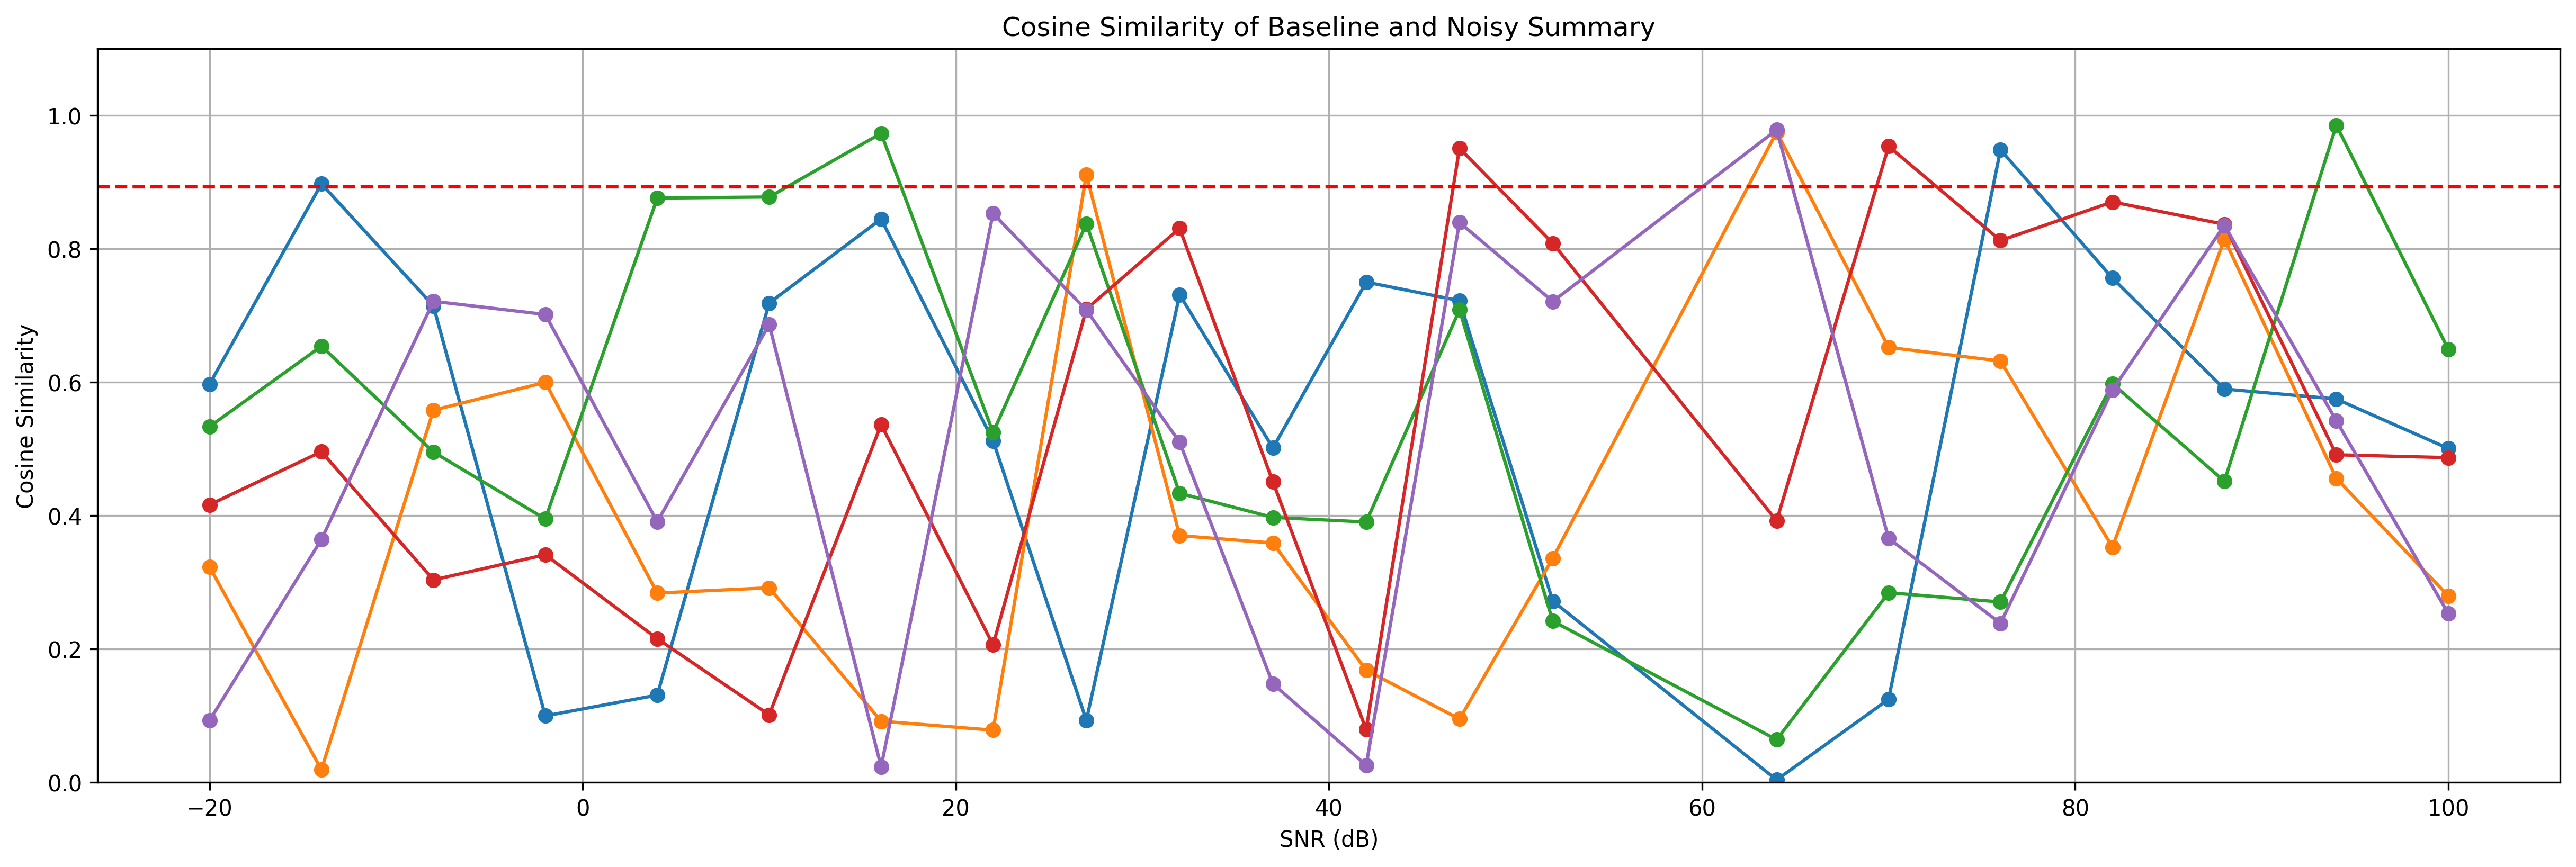

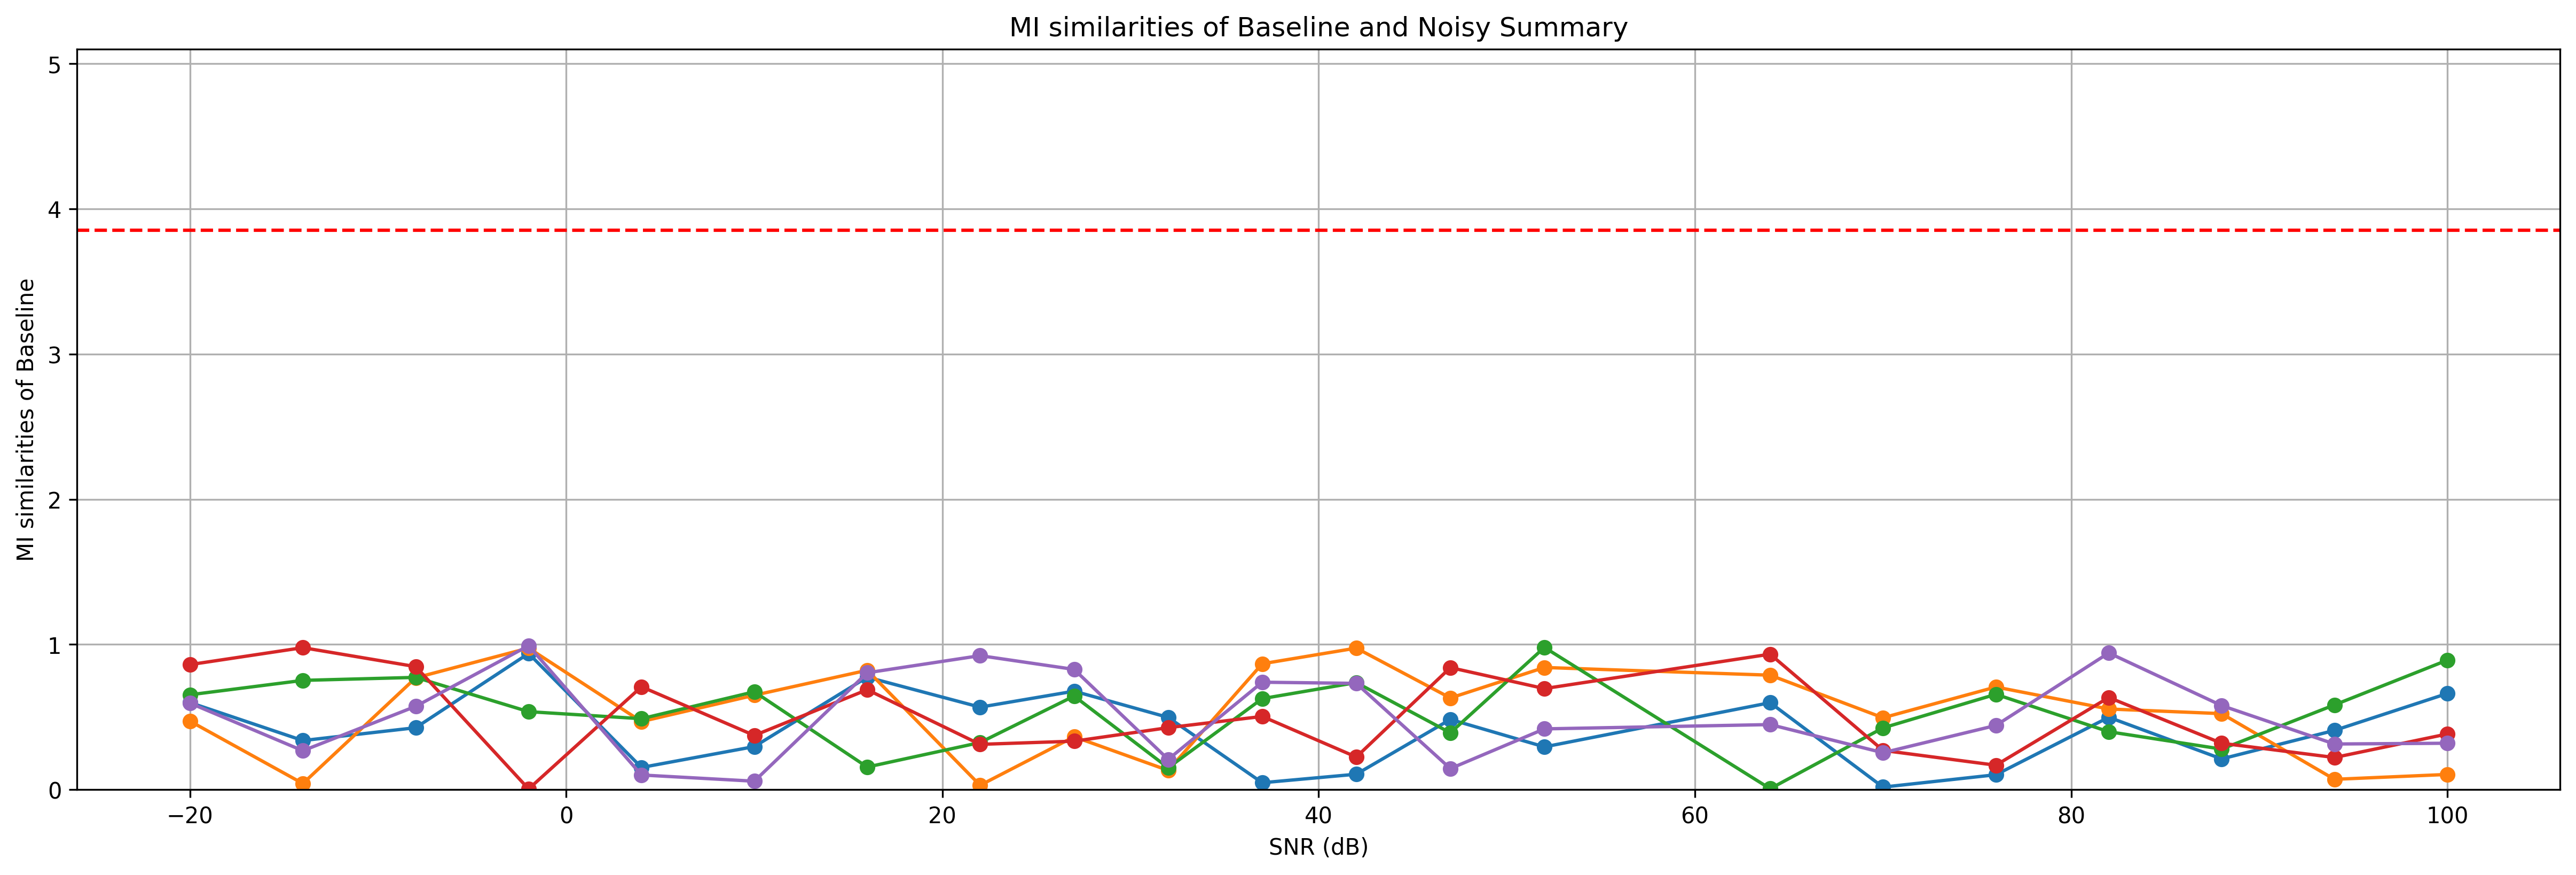

In [29]:
cs_base_orig_ls = []
mi_base_orig_ls = []
for i in range(nr_rounds):
    pad_em_baseline_summary, pad_em_original_summary = align_tensors(em_baseline_summary[i], em_original_summary)
    cs_base_orig_ls.append(F.cosine_similarity(pad_em_baseline_summary, pad_em_original_summary, dim=1).mean().item())

    em_original_summary_np = em_original_summary.cpu().numpy()
    em_baseline_summary_np = em_baseline_summary[i].cpu().numpy()

    mi_base_orig_ls.append(ksg(em_baseline_summary_np, em_original_summary_np))
    
cs_base_orig = np.mean(cs_base_orig_ls)
mi_base_orig = np.mean(mi_base_orig_ls)

plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, cs_list, marker='o')
plt.axhline(y=cs_base_orig, color='r', linestyle='--', label='Cosine Similarity between the baseline and the original')
plt.ylim([0.0,1.1])
plt.xlabel("SNR (dB)")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Baseline and Noisy Summary")
plt.grid()
plt.show()

plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, mi_list, marker='o')
plt.axhline(y=mi_base_orig, color='r', linestyle='--', label='Mutual Information between the baseline and the original')
plt.ylim([0.0,5.1])
plt.xlabel("SNR (dB)")
plt.ylabel("MI similarities of Baseline")
plt.title("MI similarities of Baseline and Noisy Summary")
plt.grid()
plt.show()


In [ ]:
# # 保存第一张图
plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, cs_list, marker='o')
plt.axhline(y=cs_base_orig, color='r', linestyle='--', label='Cosine Similarity between the baseline and the original')
plt.ylim([0.0, 1.1])
plt.xlabel("SNR (dB)")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Baseline and Noisy Summary")
plt.grid()
# plt.savefig("cosine_similarity_plot_afterCorrection.png", bbox_inches='tight')  # 保存图片
# plt.show()

# 保存第二张图
plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, mi_list, marker='o')
plt.axhline(y=mi_base_orig, color='r', linestyle='--', label='Mutual Information between the baseline and the original')
plt.ylim([0.0, 5.1])
plt.xlabel("SNR (dB)")
plt.ylabel("MI similarities of Baseline")
plt.title("MI similarities of Baseline and Noisy Summary")
plt.grid()
# plt.savefig("mi_similarity_plot_afterCorrection.png", bbox_inches='tight')  # 保存图片
plt.show()

pad_em_noisy_summary

dot_product_dim1 = (pad_em_baseline_summary * pad_em_noisy_summary).sum(dim=1)  
norm_baseline_dim1 = pad_em_baseline_summary.norm(p=2, dim=1)  
norm_noisy_dim1 = pad_em_noisy_summary.norm(p=2, dim=1)        
cosine_similarity_dim1 = dot_product_dim1 / (norm_baseline_dim1 * norm_noisy_dim1 + 1e-8)  

dot_product_dim0 = (pad_em_baseline_summary * pad_em_noisy_summary).sum(dim=0)  
norm_baseline_dim0 = pad_em_baseline_summary.norm(p=2, dim=0)  
norm_noisy_dim0 = pad_em_noisy_summary.norm(p=2, dim=0)        
cosine_similarity_dim0 = dot_product_dim0 / (norm_baseline_dim0 * norm_noisy_dim0 + 1e-8)  

flatten_baseline = pad_em_baseline_summary.flatten()
flatten_noisy = pad_em_noisy_summary.flatten()
dot_product_flat = (flatten_baseline * flatten_noisy).sum()
norm_baseline_flat = flatten_baseline.norm(p=2)
norm_noisy_flat = flatten_noisy.norm(p=2)
cosine_similarity_flat = dot_product_flat / (norm_baseline_flat * norm_noisy_flat + 1e-8)

print("Cosine Similarity (dim=1):", cosine_similarity_dim1.mean())
print("Cosine Similarity (dim=0):", cosine_similarity_dim0.mean())
print("Cosine Similarity (flattened):", cosine_similarity_flat.mean())

In [27]:
cs_std

array([0.17711025, 0.29341077, 0.15479872, 0.21010647, 0.26252042,
       0.2903512 , 0.38411284, 0.27142477, 0.29005149, 0.17666142,
       0.12169622, 0.26484177, 0.29740589, 0.23940473, 0.42452069,
       0.29377814, 0.2845712 , 0.17506827, 0.15741092, 0.19216011,
       0.14847427])